In [38]:
from hands import process
import os
import imageio.v3 as imageio
from matplotlib import pyplot as plt
import numpy as np
import string
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.src.models import Sequential
from keras.src.layers import Dense, Dropout

In [39]:
asl_dict = {char: [] for char in string.digits + string.ascii_lowercase}
asl_dir = "asl_dataset"

sub_dirs = sorted([d for d in os.listdir(asl_dir) if os.path.isdir(os.path.join(asl_dir, d))])

for dir in sub_dirs:
    cur = os.path.join(asl_dir,dir)
    for img in os.listdir(cur):
        image_path = os.path.join(cur, img)
        im = imageio.imread(image_path)
        frame, landmarks = process(im, False, 1)
        try:
            asl_dict[dir].append(landmarks)
        except Exception as e:
            print(f'{e}: error adding to dict')

I0000 00:00:1730775934.442268 8729711 gl_context.cc:357] GL version: 2.1 (2.1 ATI-5.5.17), renderer: AMD Radeon Pro 5300M OpenGL Engine
W0000 00:00:1730775934.461797 8955541 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1730775934.485406 8955545 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1730775934.515920 8729711 gl_context.cc:357] GL version: 2.1 (2.1 ATI-5.5.17), renderer: AMD Radeon Pro 5300M OpenGL Engine
W0000 00:00:1730775934.535836 8955546 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1730775934.552745 8955557 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [40]:
X = []
y = []

for label, landmarks_list in asl_dict.items():
    for landmarks in landmarks_list:
        if landmarks is not None and len(landmarks) == 63:  
            X.append(landmarks)
            y.append(label)

X = np.array(X, dtype=np.float32)  
y = np.array(y)  

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y) 

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


In [68]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(63,)),  
    Dropout(0.2),  
    Dense(64, activation='relu'), 
    Dropout(0.2), 
    Dense(32, activation='relu'),
    Dropout(0.2), 
    Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [69]:
history = model.fit(X_train, y_train, epochs=150, batch_size=8, validation_data=(X_test, y_test))


Epoch 1/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0242 - loss: 3.5877 - val_accuracy: 0.0552 - val_loss: 3.5250
Epoch 2/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0559 - loss: 3.5271 - val_accuracy: 0.0613 - val_loss: 3.4420
Epoch 3/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0719 - loss: 3.4336 - val_accuracy: 0.1258 - val_loss: 3.3185
Epoch 4/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0946 - loss: 3.3320 - val_accuracy: 0.1687 - val_loss: 3.1315
Epoch 5/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1109 - loss: 3.1755 - val_accuracy: 0.1718 - val_loss: 2.9029
Epoch 6/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1627 - loss: 2.9380 - val_accuracy: 0.2393 - val_loss: 2.6592
Epoch 7/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1849 - loss: 2.7496 - val_accuracy: 0.3834 - val_loss: 2.4196
Epoch 8/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2074 - loss: 2.5828 - val_accuracy: 0.3773 - v

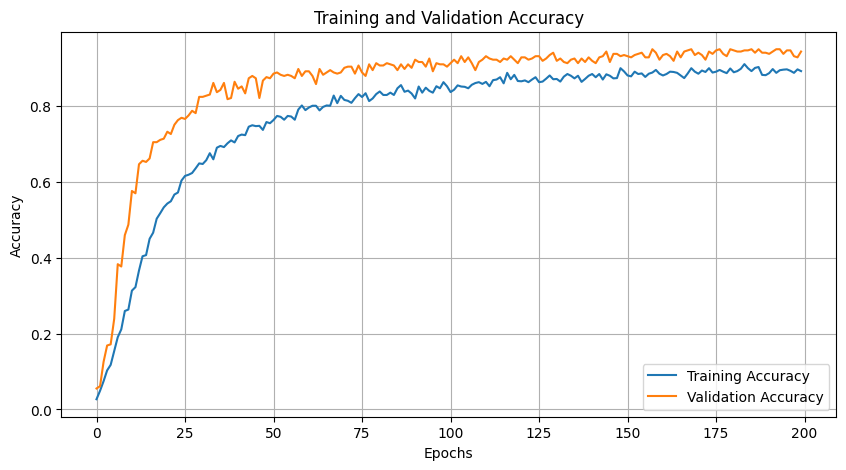

In [70]:
plt.figure(figsize=(10, 5))

plt.plot(history.history['accuracy'], label='Training Accuracy')

plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [44]:
model.save('asl-model.keras')